# Analysis of Variation Types in Feature Spaces

## 1. Comparison of Performance of a Traditional Learner in Different Variation Patterns
We try to observe any recurring pattern in terms of performance when variation pattern differs.

german varying_gaussian + 0 opcbackprop 0.38980000000000004
ionosphere varying_gaussian + 0 opcbackprop 0.43657142857142855
spambase varying_gaussian + 0 opcbackprop 0.23832608695652174
magic04 varying_gaussian + 0 opcbackprop 0.36648088753351915
a8a varying_gaussian + 0 opcbackprop 0.26913993655269647

german varying_gaussian + 0.25 opcbackprop 0.39095
ionosphere varying_gaussian + 0.25 opcbackprop 0.44699999999999995
spambase varying_gaussian + 0.25 opcbackprop 0.2555217391304348
magic04 varying_gaussian + 0.25 opcbackprop 0.37238025132761976
a8a varying_gaussian + 0.25 opcbackprop 0.275066090941135

german varying_gaussian + 0.5 opcbackprop 0.39285
ionosphere varying_gaussian + 0.5 opcbackprop 0.4321428571428572
spambase varying_gaussian + 0.5 opcbackprop 0.2663804347826087
magic04 varying_gaussian + 0.5 opcbackprop 0.37388401072611605
a8a varying_gaussian + 0.5 opcbackprop 0.279373017271766



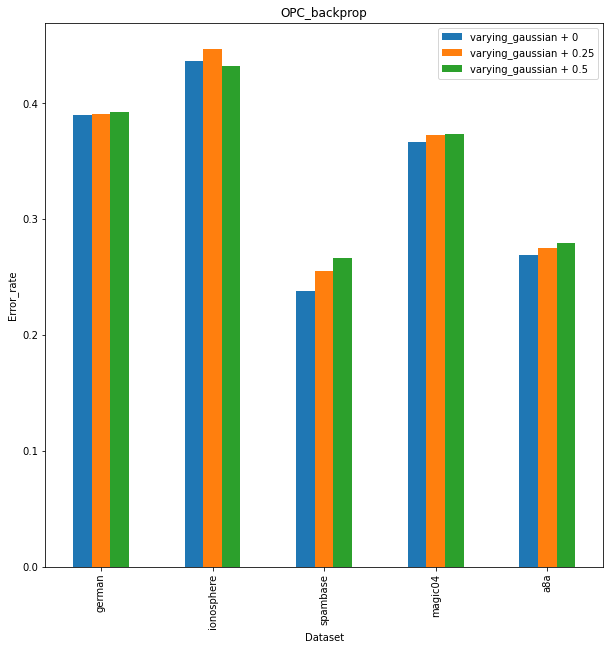

In [1]:
import model
import dataloader as dl
import numpy as np
import trainer
import parameters as p
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

datasets = ['german', 'ionosphere', 'spambase', 'magic04', 'a8a']
model_type = 'opcbackprop'


# initialize results dict
results = {}
masks = {}
occurrences = {}

for dataset in datasets:
    results[dataset] = {}
    masks[dataset] = {}
    occurrences[dataset] = {}
    for scenario in p.scenarios:
        results[dataset][scenario] = 0
        masks[dataset][scenario] = []

for scenario in p.scenarios:
    for dataset_name in p.datasets:
        Xpath, ypath = dl.get_path(dataset_name)
        X, y = dl.read_dataset(Xpath, ypath)
        num_features = len(X[0])
        m = p.models[model_type](num_features, p.learning_rate)
        fold_errors, fold_losses, fold_weights, fold_masks = trainer.cross_validation(X, y, m, p.folds, p.scenarios[scenario],p.cov_strength[scenario])
        masks[dataset_name][scenario] = fold_masks
        results[dataset_name][scenario] = np.mean(fold_errors)
        print(dataset_name, scenario, model_type, np.mean(fold_errors))
    print()    
    
    
# plot results for each dataset
'''
for dataset_name in datasets:
    plt.title(dataset_name)
    plt.ylabel('Error Rate')
    plt.bar(results[dataset_name].keys(), results[dataset_name].values())
    plt.show()
'''
df = pd.DataFrame(results).T
ax = df.plot(kind="bar",figsize=(10, 10),title ="OPC_backprop")
ax.set_xlabel("Dataset")
ax.set_ylabel("Error_rate")
fig = ax.get_figure()
fig.savefig('OPC_backprop_cov.png')



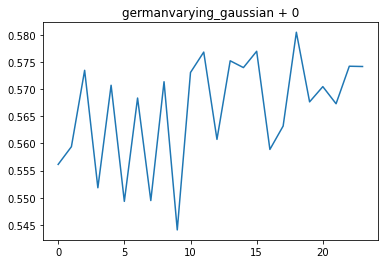

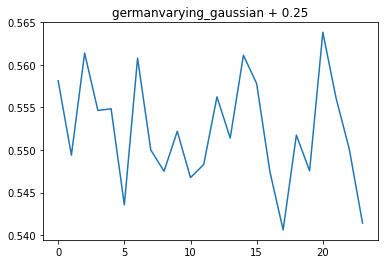

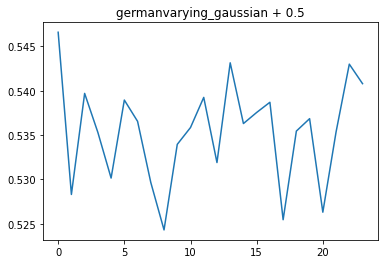

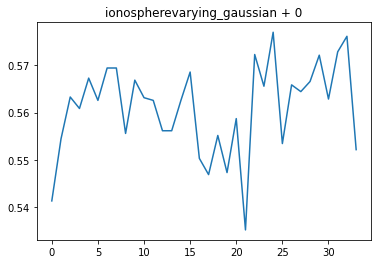

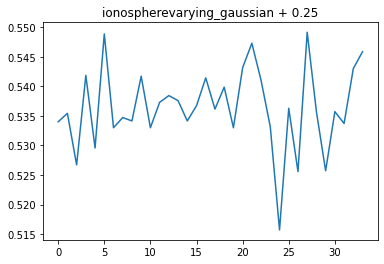

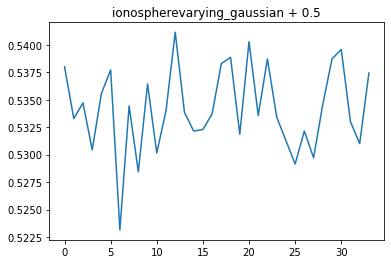

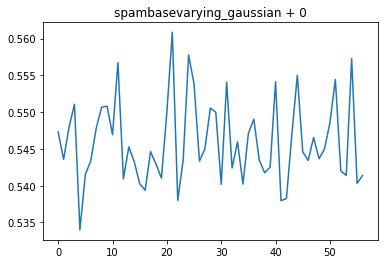

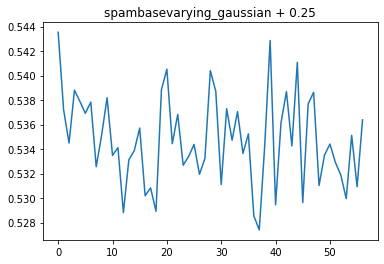

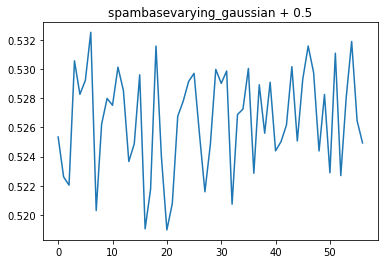

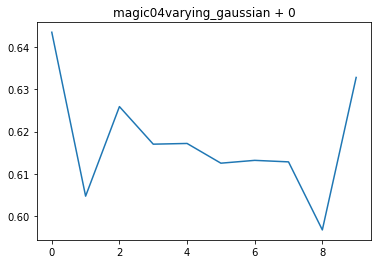

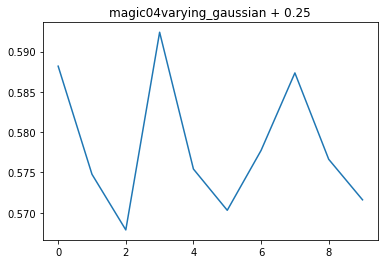

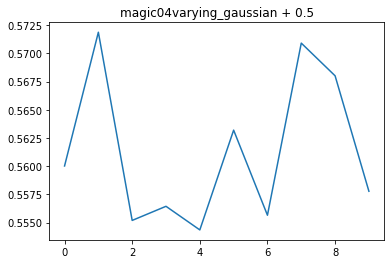

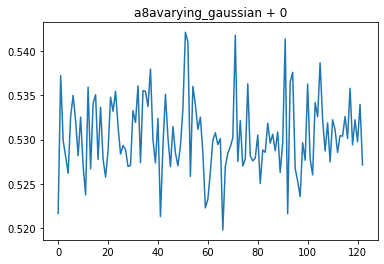

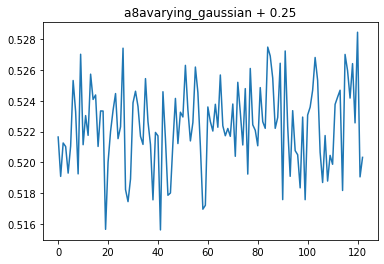

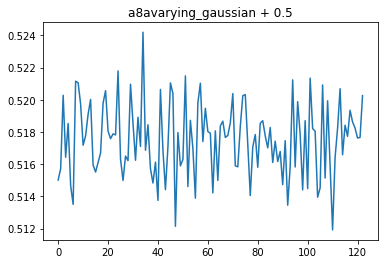

In [2]:
for key in masks:
    for scenario in p.scenarios:
        sum_masks = copy.deepcopy(masks[key][scenario][0])
        for i in range(1, len(masks[key][scenario])):
            sum_masks += masks[key][scenario][i]

        avg_sum_masks =  sum_masks / len(masks[key][scenario])
        avg_sum_masks = np.sum(avg_sum_masks, axis=0) / len(sum_masks)
        occurrences[key][scenario] = avg_sum_masks
        
        plt.title(key + scenario)
        plt.plot(occurrences[key][scenario])
        plt.show()

**We have made two observations so far:**
1. Performance in non-uniformly distributed variation in feature spaces is worse than uniform.
2. Checking the average availability frequency of features don't immediately give an explanation about this.

After this, Jeev suggested to look at the co-occurrences of features.

## Performance vs. Feature Co-Occurrence Patterns
Let us take the *german* dataset and see how feature co-occurrences look like in different versions of the variation.
To do this, we first merge the masks from different folds of cross-validation we have.
Masks represent the feature availability in a training instance, therefore, useful when we are working on structures of feature spaces.


In [3]:
def show_cov_mat(masks, dataset, setting):
    m = masks[dataset][setting]
    joint_mask = m[0]
    
    for i in range(1, len(m)):
        joint_mask = np.vstack((joint_mask, m[i]))
    
    cov_mat = np.cov(joint_mask.T)
    sns.heatmap(cov_mat)
    plt.show()
    return cov_mat


settings = ['full', 'varying_uniform', 'varying_gaussian']

for dataset in datasets:
    for setting in settings:
        print(dataset)
        show_cov_mat(masks, dataset, setting)

german


KeyError: 'full'

We see that an important is that varying feature spaces distribution in a uniform fashion have low covariance -> feature co-occurrence. This means feature occurrences don't follow a particular pattern. On the other hand, for gaussian, there exists various amounts of covariance between features, starting to form a pattern. This seems to be making learning harder for some reason.

**Note:** In both cases, the diagonal of the matrix seems to be 0.25. Diagonals of a covariance matrix are the variances of the components of the vector.

## Relationship Between the Amount of Covariance in Varying Gaussian and the Traditional Model Performance
In this section, we take the generator of varying_gaussian and modify it in a way that it removes features in different levels of variation.